In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import pymc3 as pm

import arviz as ar
import matplotlib.pyplot as pl
from matplotlib import rcParams
import seaborn as sb
%matplotlib inline

In [2]:
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16

In [3]:
home = Path.home()

### Methods

The dataset used in this study was generated from the NOMAD dataset. 6 Rrs bands were used at 6 wavelength corresponding to SeaWiFS spectral coverage; 412, 443, 490, 510, 555, 670 nm. The following data transformation steps were implemented:
* invalid data points were flagged and dropped
* for band ratio algorithms, relevant ratios were pre-computed
* for band ratio algorithms with max(Blue) formulation blue band used in the ratio was identified and flagged
* for PCA-based algorithms, principal components were computed for all bands.
* chlorophyll measurement method was identified and flagged
* all predictors were standardized

In [4]:
nomad_file = home / 'DATA/nomad_seabass_v2.a_2008200.txt'
with open(nomad_file) as f:
    for i, line in enumerate(f.readlines()):
        if 'fields' in line:
            columns = line.split('=')[1].split(',')
            continue
        if '/end_header' in line:
            skiprows = i+1

In [5]:
df_raw = pd.read_csv(nomad_file, names=columns, skiprows=skiprows,
                     na_values=-999)

In [6]:
bands = [411, 443, 489, 510, 555, 670]

In [7]:
df_raw.loc[:, [f'lw{band}' for band in bands]].describe()

,lw411,lw443,lw489,lw510,lw555,lw670
count,4304.000000,4456.000000,4431.000000,3492.000000,3312.000000,1602.000000
mean,0.385876,0.433970,0.450727,0.416742,0.330696,0.136143
std,0.418701,0.437093,0.390907,0.368770,0.430900,0.231025
min,0.001019,0.001470,0.001470,0.001250,0.000600,0.000000
25%,0.099433,0.118075,0.150520,0.188368,0.120175,0.016921
50%,0.235650,0.280952,0.347400,0.347605,0.210395,0.055817
75%,0.501023,0.609602,0.657315,0.524745,0.330312,0.159858
max,3.525270,2.988000,3.592700,4.398700,6.288500,3.222200


In [8]:
df_raw.loc[:, [f'es{band}' for band in bands]].describe()

,es411,es443,es489,es510,es555,es670
count,4305.000000,4459.000000,4450.000000,3446.000000,3258.000000,1616.000000
mean,73.540755,85.777988,93.053646,99.686608,97.828945,96.691502
std,42.527826,49.526399,52.812348,47.437513,45.437147,37.233330
min,0.412000,0.489000,0.479000,0.420000,0.284000,1.287880
25%,34.741000,40.442000,44.969450,61.575050,62.379225,74.092875
50%,75.080000,88.201800,96.760450,105.335000,104.924000,102.500000
75%,110.525000,127.631500,138.594000,139.984750,136.329000,123.000000
max,216.678000,238.739000,249.221000,252.287000,243.629000,194.600000


In [9]:
for band in bands:
    df_raw[f'rrs{band}'] = df_raw[f'lw{band}'] / df_raw[f'es{band}']
columns = df_raw.filter(regex='rrs', axis=1).columns
columns = ['id'] + columns.tolist() + ['chl', 'chl_a']
df = df_raw[columns].copy()

df.head()

,id,rrs411,rrs443,rrs489,rrs510,rrs555,rrs670,chl,chl_a
0,1565,0.001204,0.001686,0.003293,0.004036,0.007479,0.003465,38.19,NaN
1,1566,0.001062,0.001384,0.002173,0.002499,0.004152,0.001695,35.01,NaN
2,1567,0.000971,0.001185,0.001843,0.002288,0.004246,0.001612,26.91,NaN
3,1568,0.001472,0.001741,0.002877,0.003664,0.006982,0.003234,47.96,NaN
4,1559,0.000905,0.001022,0.001506,0.001903,0.002801,0.001791,23.55,NaN


In [10]:
df.describe()

,id,rrs411,rrs443,rrs489,rrs510,rrs555,rrs670,chl,chl_a
count,4459.000000,4293.000000,4456.000000,4422.000000,3435.000000,3255.000000,1598.000000,3392.000000,1381.000000
mean,4377.381251,0.004881,0.004652,0.004590,0.004130,0.003256,0.001557,2.703251,2.285293
std,2298.272102,0.003447,0.003002,0.002768,0.003130,0.003536,0.002387,5.611762,5.752391
min,6.000000,0.000051,0.000190,0.000284,0.000261,0.000183,0.000000,0.012000,0.017000
25%,2028.500000,0.002509,0.002617,0.003051,0.002831,0.001588,0.000200,0.274000,0.145000
50%,5039.000000,0.003984,0.003899,0.004153,0.003425,0.002071,0.000614,0.830000,0.538000
75%,6271.500000,0.006301,0.006076,0.005655,0.004242,0.003141,0.002000,2.240080,1.694000
max,7831.000000,0.030600,0.036769,0.063814,0.077740,0.046600,0.027700,77.864800,70.213300


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 9 columns):
id        4459 non-null int64
rrs411    4293 non-null float64
rrs443    4456 non-null float64
rrs489    4422 non-null float64
rrs510    3435 non-null float64
rrs555    3255 non-null float64
rrs670    1598 non-null float64
chl       3392 non-null float64
chl_a     1381 non-null float64
dtypes: float64(8), int64(1)
memory usage: 313.6 KB


In [12]:
#chlorophyll measurement method was identified and flagged
def fill_chl(row):
    return row['chl_a'] if np.isfinite(row['chl_a']) else row['chl']

df['chlor_a'] = df.apply(fill_chl, axis=1)
df['is_hplc'] = np.isfinite(df.chl_a)
df.drop(['chl', 'chl_a'], axis=1, inplace=True)

In [13]:
df_clean = df.dropna().copy()

In [14]:
df_clean.to_pickle('./df_clean.pkl')
df.to_pickle('./df_main.pkl')
df_raw.to_pickle('./df_raw.pkl')

In [15]:
#for band ratio algorithms, relevant ratios were pre-computed
blue_bands = ['rrs443', 'rrs489', 'rrs510']
df_clean['MaxBlue'] = df_clean[blue_bands].max(axis=1)
#identify and flag max blue band
df_clean['MaxBlueBand'] = df_clean[blue_bands].idxmax(axis=1).str.capitalize()

In [34]:
df_clean = df_clean.loc[df_clean.rrs670 > 0, :].copy()

In [35]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 4458
Data columns (total 12 columns):
id             1016 non-null int64
rrs411         1016 non-null float64
rrs443         1016 non-null float64
rrs489         1016 non-null float64
rrs510         1016 non-null float64
rrs555         1016 non-null float64
rrs670         1016 non-null float64
chlor_a        1016 non-null float64
is_hplc        1016 non-null bool
MaxBlue        1016 non-null float64
MaxBlueBand    1016 non-null object
mxBlu2Gr       1016 non-null float64
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 96.2+ KB


In [36]:
df_clean['mxBlu2Gr'] = df_clean.MaxBlue / df_clean.rrs555

In [37]:
columns_to_log_transform = df_clean.filter(regex='(rrs|chl|mxBlu2)',
                                         axis=1).columns.tolist()

# log_transforms
df_log = pd.DataFrame(np.log10(df_clean.loc[:,
                                            columns_to_log_transform
                                           ].values),
                      columns=[f'log_{col}' 
                               for col in columns_to_log_transform])

Note on computing sd on log scale:


If Var(exp(log_rrs))≈exp$(\mu_{log\_rrs})^2\sigma^2_{log\_rrs}$

$sd(exp(log\_rrs))≈exp(\mu_{log\_rrs})\sigma_{log\_rrs}$


$\leftrightarrow \ \sigma_{log\_rrs} ≈ \frac{sd(rrs)}{exp(\mu_{log\_rrs})}$

In [38]:
df_log.insert(0, 'id', df_clean.id)
df_log.insert(df_log.columns.get_loc('log_mxBlu2Gr'), 
             'MaxBlueBand', df_clean.MaxBlueBand)
df_log['is_hplc'] = df_clean.is_hplc

df_log = df_log[['id', 'log_rrs411', 'log_rrs443', 'log_rrs489',
                 'log_rrs510', 'log_rrs555', 'log_rrs670' ,
                 'MaxBlueBand', 'log_mxBlu2Gr',
                 'log_chlor_a', 'is_hplc']]

df_log.head()

,id,log_rrs411,log_rrs443,log_rrs489,log_rrs510,log_rrs555,log_rrs670,MaxBlueBand,log_mxBlu2Gr,log_chlor_a,is_hplc
0,1565.0,-2.919229,-2.773122,-2.482397,-2.394012,-2.126145,-2.460352,Rrs510,-0.267867,1.581950,False
1,1566.0,-2.973995,-2.858857,-2.662956,-2.602191,-2.381734,-2.770862,Rrs510,-0.220457,1.544192,False
2,1567.0,-3.012722,-2.926105,-2.734427,-2.640597,-2.372060,-2.792560,Rrs510,-0.268537,1.429914,False
3,1568.0,-2.832150,-2.759143,-2.541014,-2.436014,-2.156039,-2.490282,Rrs510,-0.279976,1.680879,False
4,1559.0,-3.043308,-2.990409,-2.822196,-2.720468,-2.552735,-2.747020,Rrs510,-0.167733,1.371991,False


In [39]:
df_log.filter(regex='rrs', axis=1).describe()

,log_rrs411,log_rrs443,log_rrs489,log_rrs510,log_rrs555,log_rrs670
count,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000
mean,-2.469966,-2.434733,-2.348028,-2.372404,-2.419356,-3.175779
std,0.372152,0.322377,0.277348,0.276308,0.352022,0.588881
min,-4.290672,-3.721171,-3.435402,-3.303393,-3.379701,-4.440321
25%,-2.698900,-2.631142,-2.513907,-2.537605,-2.724524,-3.698398
50%,-2.468523,-2.420232,-2.328363,-2.420169,-2.486567,-3.212071
75%,-2.187091,-2.207596,-2.193829,-2.214667,-2.142606,-2.699023
max,-1.514280,-1.559082,-1.519995,-1.482807,-1.331613,-1.557521


In [40]:
#Compute PC for all bands, for PCA-based regression algorithms
pc_transformer = PCA()
PCs = pc_transformer.fit_transform(df_log.filter(regex='rrs',
                                                 axis=1).dropna()
                                  )

df_pc = pd.DataFrame(PCs, columns = [f'pc{i+1}' 
                                     for i in range(PCs.shape[1])])

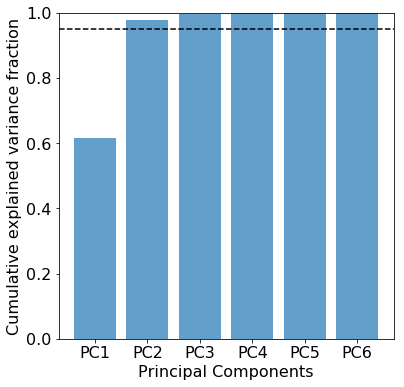

In [41]:
# Plotting explained variance of principle components
_, ax = pl.subplots(figsize=(6, 6))
ax.bar([f'PC{i}' for i in range(1, 7)],
       np.cumsum(pc_transformer.explained_variance_ratio_),
       alpha=0.7);
ax.set_ylabel('Cumulative explained variance fraction')
ax.set_xlabel('Principal Components');
ax.set_ylim(0, 1)
ax.axhline(0.95, color='k', ls='--');

Before a principled statistical comparison of the different chlorophyll algorithms becomes possible, the different algorithms must be re-implemented using a Bayesian framework. The implementation follows the sequence below:

* Model coding using a probabilistic programming language (PPL)
* Prior predictive simulation 
* Model fitting using Hamiltonian Monte Carlo and the Nomad dataset
* Posterior predictive simulation to quantify predictive uncertainty
* Comparison of Model skill  on out-of-sample data using Information Criteria (IC) including Watanabe Akaike Information Criterion (WAIC) and/or Pareto Smoothed Importance Sampling Leave One Out Cross Validation (LOO).


1. Implementation of $OC_4$ 


    A. Without chlorophyll measurement error

In [42]:
X = df_log.log_mxBlu2Gr.values
y = df_log.log_chlor_a.values
X_poly = np.c_[X, np.power(X, 2), np.power(X, 3), np.power(X, 4)]

In [43]:
X_poly.shape

(1016, 4)

In [44]:
with pm.Model() as m_oc4:
    α = pm.Normal('α', 0, 1)
    β = pm.Normal('β', 0, 1, shape=X_poly.shape[1])
    σ = pm.Exponential('σ', 1)
    μ =  pm.math.dot(X_poly, β)
    log_chl = pm.Normal('log_chl', mu=μ, sd=σ, observed=y)

In [48]:
m_oc4_priors = pm.sample_prior_predictive(model=m_oc4,
                                         vars=['α', 'β', 'σ'])

In [45]:
with m_oc4:
    trace_oc4 = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, α]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:19<00:00, 310.80draws/s]


In [49]:
m_oc4_posteriors = {k: trace_oc4.get_values(k) for k in ['α', 'β', 'σ']}

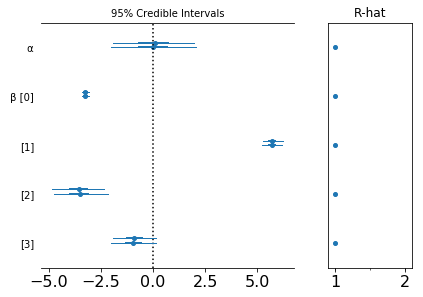

In [47]:
pm.forestplot(trace_oc4, varnames=['α', 'β']);

    B. With chlorophyll measurement error

2. Implementation of $OC_x$ with $CI$ split


    A. Without chlorophyll measurement error

    B. With chlorophyll measurement error

3. Simple band ratio

    A. Without chlorophyll measurement error

    B. With chlorophyll measurement error

4. Multivariate Linear Regression


    A. Without chlorophyll measurement error

    B. With chlorophyll measurement error

5. Multivariate Linear Regression with Prior Transformation of Principal Components of Reflectance

    A. Without chlorophyll measurement error

    B. With chlorophyll measurement error